# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import scrnatools as rna
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

In [3]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"
sc.set_figure_params(dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False

In [4]:
warnings.resetwarnings()

## Set up file paths

### demeter

In [5]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [6]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

## Import data

In [7]:
aire_1 = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/pairwise_processing/aire_1_TECs.h5ad")
aire_2 = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/pairwise_processing/aire_2_TECs.h5ad")
fezf2_1 = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/pairwise_processing/fezf2_1_TECs.h5ad")
fezf2_2 = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/pairwise_processing/fezf2_2_TECs.h5ad")
adatas = {"Aire_1": aire_1, "Aire_2": aire_2, "Fezf2_1": fezf2_1, "Fezf2_2": fezf2_2}

# Differential Density

In [8]:
for key,adata in adatas.items():
    print(key)
    adata = rna.tl.log_density_ratio(
        adata,
        group_by="genotype",
        groups=[f"{key.split('_')[0]}_WT", f"{key.split('_')[0]}_KO"],
        key_added=f"{key.split('_')[0]}_KO/WT_genotype_density",
        latent_rep="X_umap",
    )
    adatas[key] = adata

Aire_1
Aire_2
Fezf2_1
Fezf2_2


Aire_1


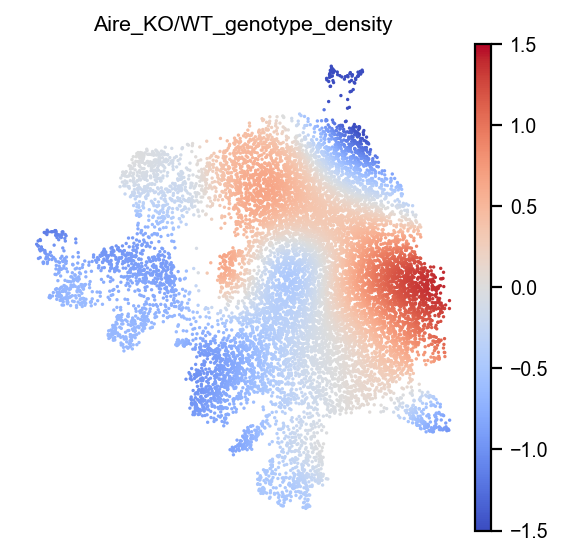

Aire_2


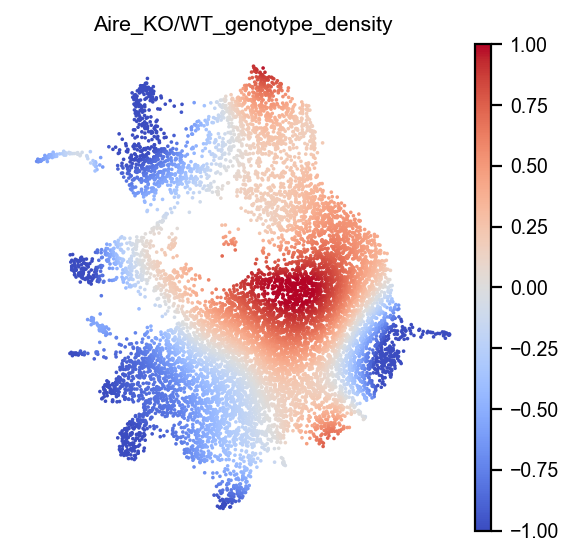

Fezf2_1


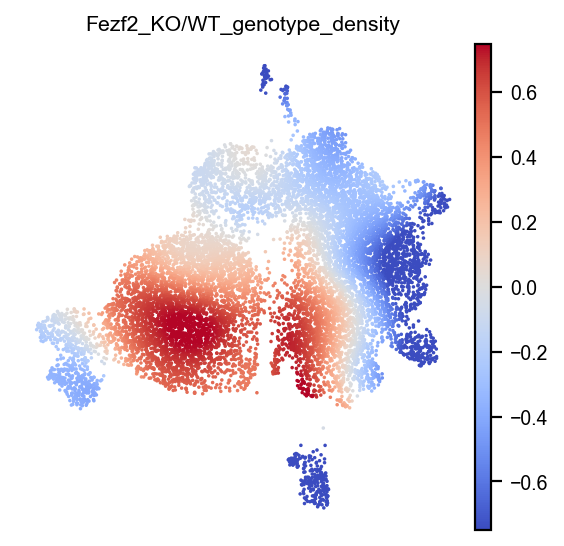

Fezf2_2


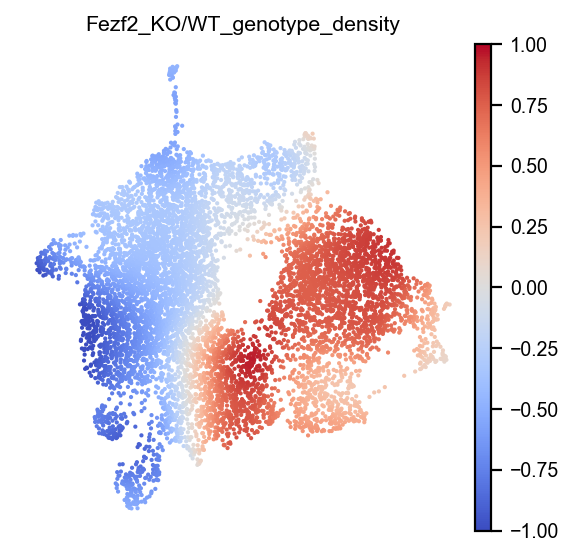

In [16]:
colorbar_limits = {"Aire_1": 1.5, "Aire_2": 1, "Fezf2_1": 0.75, "Fezf2_2": 1}
for key,adata in adatas.items():
    print(key)
    sc.settings.figdir = "../analysis/paper_figures/1/"
    sc.pl.umap(
        adata,
        color=f"{key.split('_')[0]}_KO/WT_genotype_density",
        cmap="coolwarm",
        vmin=-1*colorbar_limits[key],
        vmax=colorbar_limits[key],
        # save="_1D_Fezf2_KO_density.pdf"
    )

# Cell type abundance

In [18]:
all_merged = ad.concat(adatas.values(), index_unique="-")

In [19]:
counts = pd.DataFrame(index=all_merged.obs.majority_voting.unique())
for key,adata in adatas.items():
    wt_counts = pd.DataFrame(
        adata[adata.obs.genotype == f"{key.split('_')[0]}_WT"].obs.majority_voting.value_counts()
    )
    wt_counts = wt_counts/wt_counts.sum()*100
    ko_counts = pd.DataFrame(
        adata[adata.obs.genotype == f"{key.split('_')[0]}_KO"].obs.majority_voting.value_counts()
    )
    ko_counts = ko_counts/ko_counts.sum()*100
    
    counts[f"{key.split('_')[0]}_WT-{key.split('_')[1]}"] = wt_counts
    counts[f"{key.split('_')[0]}_KO-{key.split('_')[1]}"] = ko_counts
    counts = counts.fillna(0)
    counts[f"{key.split('_')[0]}_KO-{key.split('_')[1]} LFC"] = np.log2(
        counts[f"{key.split('_')[0]}_KO-{key.split('_')[1]}"]/counts[f"{key.split('_')[0]}_WT-{key.split('_')[1]}"]
    )

/home/joe/miniconda3/envs/fezf2-thymus/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


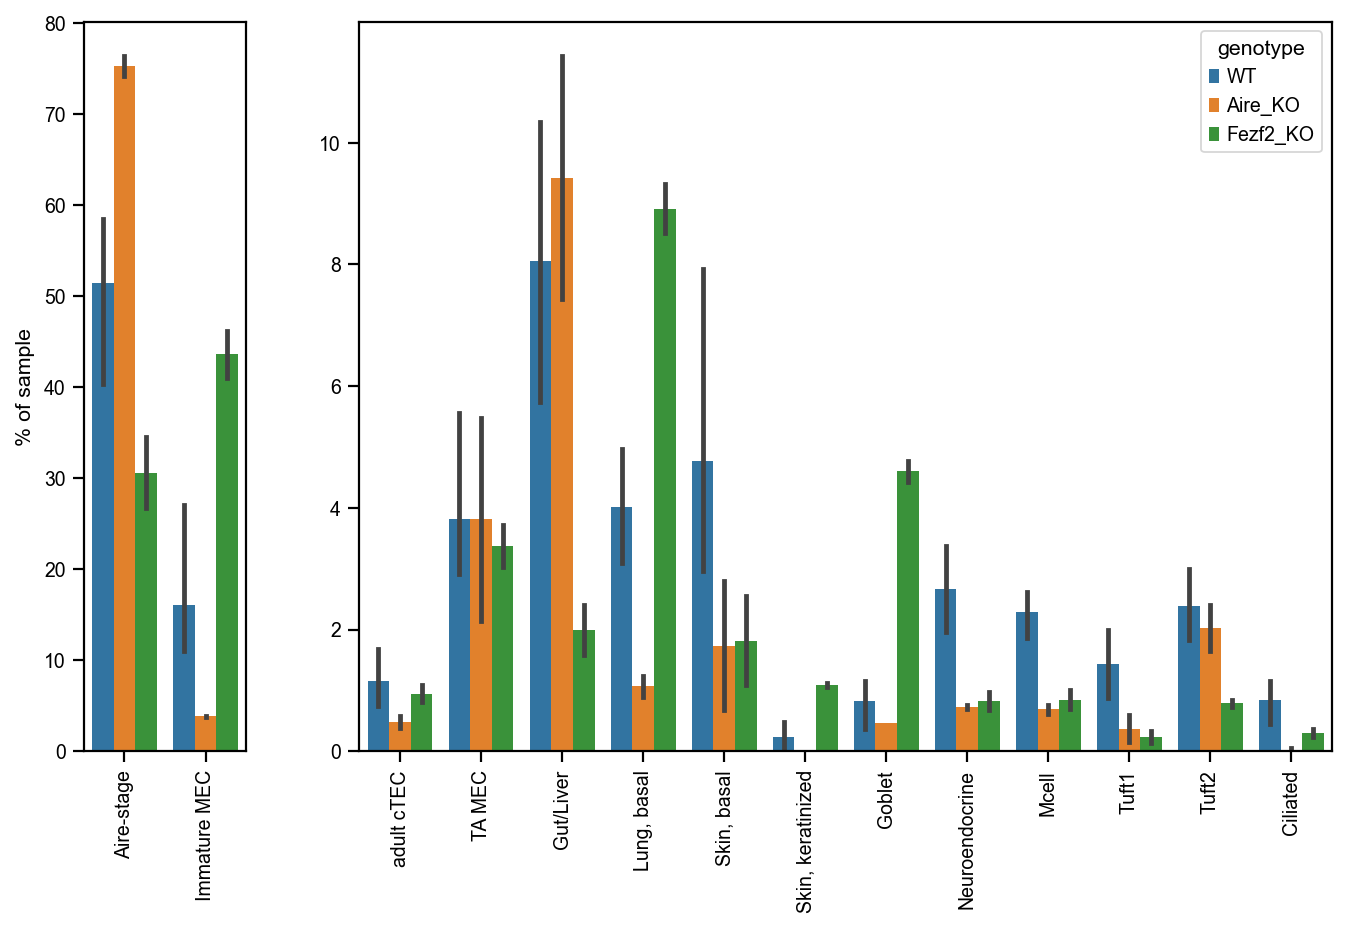

In [32]:
data = counts[counts.columns[~counts.columns.str.contains("LFC")]].T
genotypes = [i.split("-")[0] for i in data.index]
genotypes = [i.split("_")[1] if "WT" in i else i for i in genotypes]
data = data.melt()
data["genotype"] = genotypes*len(data.variable.unique())

fig, axs = plt.subplots(1,2,figsize=(10,6), gridspec_kw={'width_ratios': [1, 6]})

sns.barplot(
    data[data.variable.isin(["Aire-stage", "Immature MEC"])],
    x="variable",
    y="value",
    hue="genotype",
    errorbar=("pi", 100),
    ax=axs[0],
    order=["Aire-stage", "Immature MEC"],
    palette=["tab:blue", "tab:orange", "tab:green"]
)
# sns.stripplot(
#     data[data.variable.isin(["Aire-stage", "Immature MEC"])],
#     x="variable",
#     y="value",
#     hue="genotype",
#     dodge=True,
#     palette="dark:black",
#     s=5,
#     legend=None,
#     ax=axs[0],
#     order=["Aire-stage", "Immature MEC"],
# )
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].get_legend().remove()
axs[0].set_xlabel("")
axs[0].set_ylabel("% of sample")

sns.barplot(
    data[~data.variable.isin(["Aire-stage", "Immature MEC"])],
    x="variable",
    y="value",
    hue="genotype",
    errorbar=("pi", 100),
    ax=axs[1],
    palette=["tab:blue", "tab:orange", "tab:green"],
    order=["adult cTEC", "TA MEC", "Gut/Liver", "Lung, basal", "Skin, basal",
           "Skin, keratinized", "Goblet", "Neuroendocrine", "Mcell", "Tuft1",
           "Tuft2", "Ciliated"],
)
# sns.stripplot(
#     data[~data.variable.isin(["Aire-stage", "Immature MEC"])],
#     x="variable",
#     y="value",
#     hue="genotype",
#     dodge=True,
#     palette="dark:black",
#     s=5,
#     legend=None,
#     ax=axs[1],
#     order=["adult cTEC", "TA MEC", "Gut/Liver", "Lung, basal", "Skin, basal",
#            "Skin, keratinized", "Goblet", "Neuroendocrine", "Mcell", "Tuft1",
#            "Tuft2", "Ciliated"],
# )
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[1].set_xlabel("")
axs[1].set_ylabel("")

plt.show()

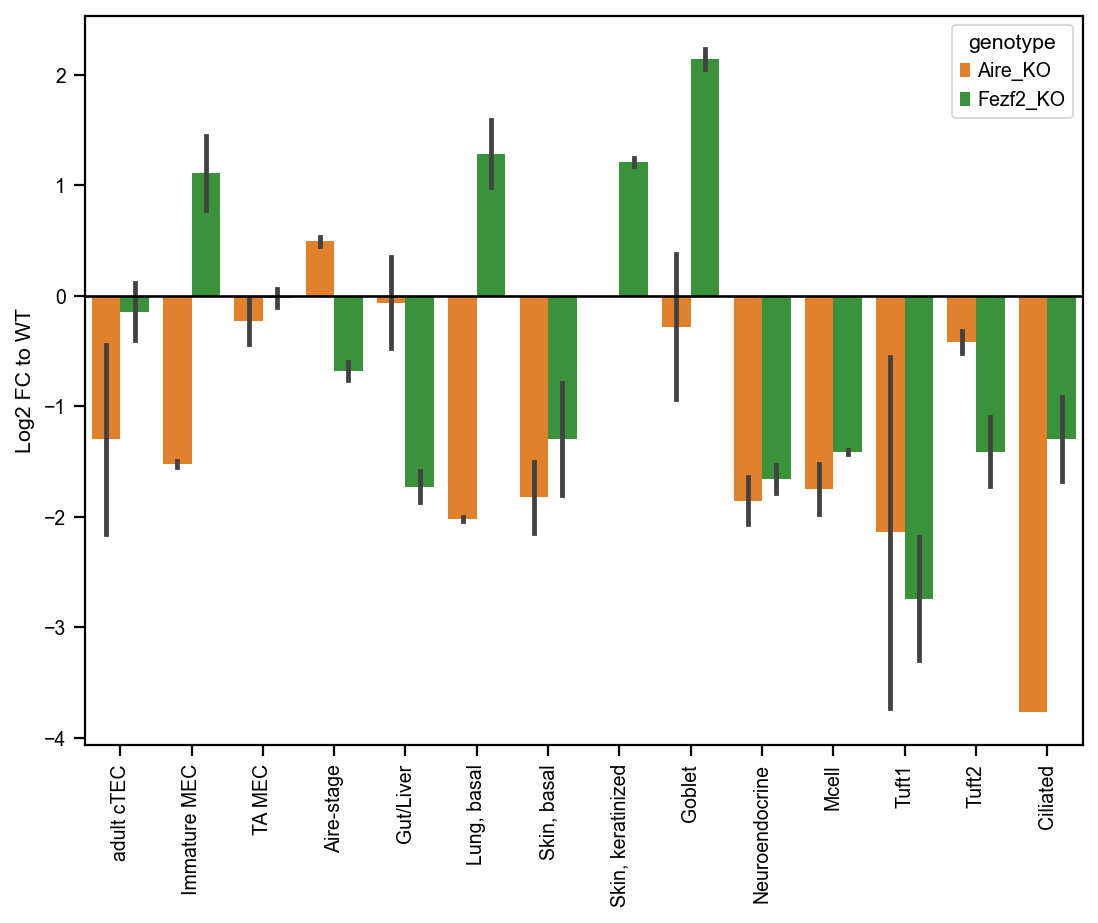

In [34]:
data = counts[counts.columns[counts.columns.str.contains("LFC")]].T
genotypes = [i.split("-")[0] for i in data.index]
data = data.melt()
data["genotype"] = genotypes*len(data.variable.unique())
data = data.replace(float('-inf'), -3.766165)

plt.figure(figsize=(8,6))
sns.barplot(
    data,
    x="variable",
    y="value",
    hue="genotype",
    errorbar=("pi", 100),
    order=["adult cTEC", "Immature MEC", "TA MEC", "Aire-stage", "Gut/Liver", 
           "Lung, basal", "Skin, basal", "Skin, keratinized", "Goblet",
           "Neuroendocrine", "Mcell", "Tuft1", "Tuft2", "Ciliated"],
    palette=["tab:orange", "tab:green"]
)
# sns.stripplot(
#     data,
#     x="variable",
#     y="value",
#     hue="genotype",
#     palette="dark:black",
#     dodge=True,
#     s=4,
#     order=["adult cTEC", "Immature MEC", "TA MEC", "Aire-stage", "Gut/Liver", 
#            "Lung, basal", "Skin, basal", "Skin, keratinized", "Goblet",
#            "Neuroendocrine", "Mcell", "Tuft1", "Tuft2", "Ciliated"],
#     legend=None,
#     jitter=False
# )
plt.axhline(y=0, c="black")
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("Log2 FC to WT")
plt.show()

In [26]:
pvalues = pd.DataFrame()
data = counts.T
data = data[~data.index.str.contains("LFC")]

for cell_type in data.columns:
    cell_type_data = pd.DataFrame(data[cell_type])
    cell_type_data["genotype"] = [i.split("-")[0] for i in cell_type_data.index]
    WT_abundance = cell_type_data[cell_type_data.genotype.str.contains("WT")][cell_type]
    for genotype in "Aire_KO", "Fezf2_KO":
        KO_abundance = cell_type_data[cell_type_data.genotype == genotype][cell_type]
        pvalue = pd.DataFrame(
            [cell_type, genotype, ttest_ind(WT_abundance, KO_abundance).pvalue],
            index=["cell_type", "genotype", "pval"]
        ).T
        pvalues = pd.concat([pvalues, pvalue], ignore_index=True)
pvalues

,cell_type,genotype,pval
0,TA MEC,Aire_KO,0.996781
1,TA MEC,Fezf2_KO,0.655491
2,Aire-stage,Aire_KO,0.015252
3,Aire-stage,Fezf2_KO,0.030007
4,Ciliated,Aire_KO,0.032527
5,Ciliated,Fezf2_KO,0.100844
6,"Skin, basal",Aire_KO,0.159522
7,"Skin, basal",Fezf2_KO,0.15651
8,Neuroendocrine,Aire_KO,0.021211
9,Neuroendocrine,Fezf2_KO,0.026381
